**Install Detectron2**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15253, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 15253 (delta 143), reused 181 (delta 105), pack-reused 14979
Receiving objects: 100% (15253/15253), 6.28 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (11010/11010), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00

Verify the torch and detectron versions

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


Import the required libraries

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

Register datasets in the COCO format. Register both the training and validation datasets.



In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/train/coco_annotations.json", "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/val/coco_annotations.json", "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/val")


In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[09/15 20:58:10 d2.data.datasets.coco]: Loaded 465 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/train/coco_annotations.json
[09/15 20:58:11 d2.data.datasets.coco]: Loaded 133 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/val/coco_annotations.json


Visualize some random images - Sanity check

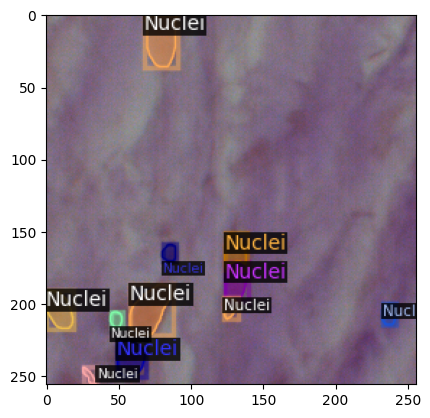

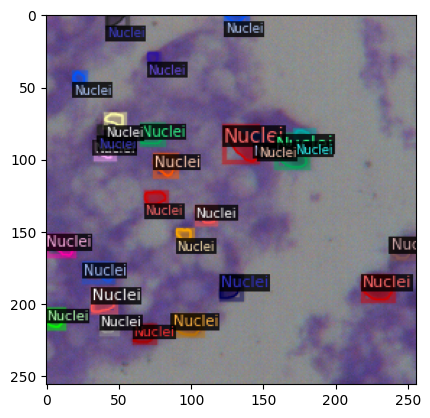

In [ ]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train <p>


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/data/NuInsSeg_Nuclei_dataset/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations for demo purposes
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[09/15 21:02:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 206MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train() #Start the training process

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard  #Reload in case you have already loaded it once

%tensorboard --logdir /content/data/NuInsSeg_Nuclei_dataset/models/Detectron2_Models/ --port 6007


In [ ]:
import yaml
import os
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/Detectron2_Models/config-5k_iter.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

#Save the model weights with a different name so we don't accidentally overwrite our model.
os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, "model_10k_iter.pth"))

# Inference & evaluation using the trained model

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_15k_iter.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom threshold
predictor = DefaultPredictor(cfg)

[09/15 21:05:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/models/Detectron2_Models/model_15k_iter.pth ...


**Verify segmentation on random test images** <p>

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test/coco_annotations.json", "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test")
test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")

[09/15 21:06:04 d2.data.datasets.coco]: Loaded 67 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test/coco_annotations.json


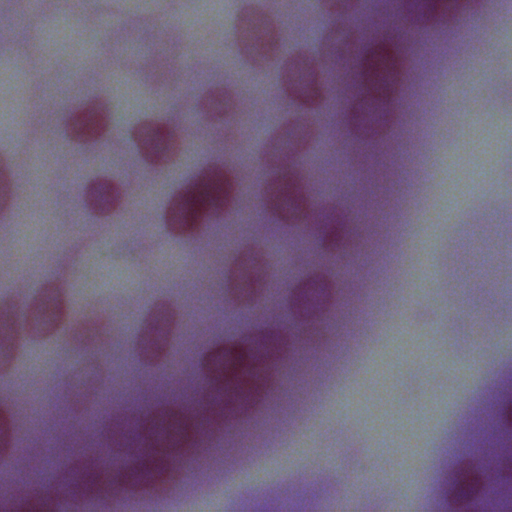

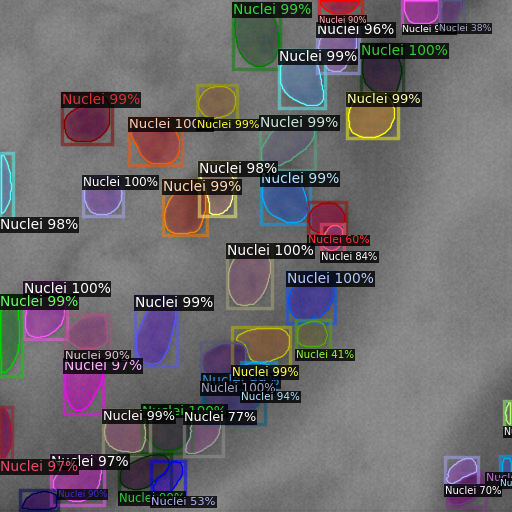

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(im[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs2 = predictor(im)

    # Perform prediction on the tile using your trained model
    outputs2 = predictor(im)

# Get the confidence scores
    scores = outputs2["instances"].scores

# Define your custom threshold
    threshold = 0.4

# Filter instances based on confidence threshold
    filtered_indices = [i for i, score in enumerate(scores) if score > threshold]

# Update the instances in the outputs
    outputs2["instances"] = outputs2["instances"][filtered_indices]

    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
    cv2_imshow(im[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])



**Check the segmentation metrics (Average Precision & recall)** <p>


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[09/15 21:09:12 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[09/15 21:09:12 d2.data.datasets.coco]: Loaded 67 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test/coco_annotations.json
[09/15 21:09:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Nuclei   | 3631         |
|            |              |
[09/15 21:09:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/15 21:09:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/15 21:09:12 d2.data.common]: Serializing 67 elements to byte tensors and concatenating them all ...
[09/15 21:09:12 d2.data.common]: Serialized dataset takes 0.94 MiB
[09/15 21:09:12 d2.evaluation.eva

**Understanding the average precision metric:**
<p>

**AP =** Average Precision <br>

**AP50 =** AP calculated using IoU threshold of 0.5. In our case, we got AP50 as 72, which means our model is performing well at this threshold. <br>

**APs (small objects):** Our score is 32 which suggests that the model's performance on small objects is lower than overall performance. <br>

**APm (medium objects):** Our score is 50 suggesting our model performs better on medium objects. <br>

**APl (large objects):** We have NaN. Could mean that we have no large objects.

